In [36]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
idx = pd.IndexSlice
pd.set_option("display.max_rows",101)
pd.set_option('expand_frame_repr', False)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# MRChem benchmark calculations

This notebook presents benchmark timings for the MRChem program on a set of molecular calculations using a variable number of CPU cores. The test systems are standard linear alkane chains $C_nH_{2n+2}$, with $n$ ranging from 2 to 350, as well as the Caffeine ($C_{8}H_{10}N_{4}O_{2}$) and Valinomycine ($C_{54}H_{90}N_{6}O_{18}$) molecules. The main purpose of this data is to monitor the development of the code performance between different version, but it will also provide a reference for users to check if the code has been properly installed and runs reasonably on their system. Not all molecular systems will be available in the data, which mirrors the current limitations of the code when it comes to system size and numerical precision. Only a small selection of the data will be presented below, but further details are available by digging into the raw data.

## MRChem SCF cycle

The Self-Consistent Field (SCF) cycle in MRChem contains the following steps:

- Building Fock operator
- Calculating Fock matrix
- Rotating orbitals (diagonalization or localization)
- Calculating SCF energy
- Applying Helmholtz operator
- Applying iterative subspace acceleration (KAIN)

and each of these may have sub steps that can be extracted from the data below. The calculations are performed using one of the following methods:

- Hartree (to show the performance of the backbone SCF algorithm + Coulomb interaction)
- Hartree-Fock (to show the performance of the exact exchange operator)
- DFT-PBE (to show the performance of the density functional integrator)

## Parallel performance

The following table presents timings (in sec) for the different parts of a single SCF cycle for the Caffeine ($C_{8}H_{10}N_{4}O_{2}$) molecule at numerical precision $\epsilon=10^{-5}$, using the PBE density functional. The calculations are using an increasing number of MPI processes and OMP threads per process. The molecule has 102 electrons and 51 doubly occupied molecular orbitals.

In [37]:
mol='caffeine'
hybrid_frame = pd.read_csv("caffeine/scf.csv", index_col=[0,1,2])
hybrid_frame.loc[mol,:,:]

Localize  SCF energy  Helmholtz    Lowdin      KAIN  Fock operator  Fock matrix  Total SCF
MPI OMP                                                                                            
1   1    539.1220   583.36200  7030.8600   91.8980  58.28970       434.3580     701.4510  9485.0700
    2    330.9390   316.29000  3616.8700   54.8294  34.82120       223.9340     417.2780  5027.0400
    4    238.8490   184.33200  1889.1900   45.0962  25.11860       117.2300     281.1450  2810.3300
    8    180.7550   112.04000  1017.2500   37.7111  17.17730        61.5682     190.9180  1642.9400
    16   168.4100    76.58830   591.5900   35.1696  13.89220        34.1444     162.8890  1107.3000
    32   153.4710    60.73820   390.7570   31.6127  13.79350        21.3100     145.8330   839.7660
2   1    309.7110   299.39900  3590.1200   62.7896  29.19360       314.7860     384.8410  5028.0100
    2    195.6530   159.30400  1837.2000   42.2049  18.06990       160.8600     230.1640  2669.6600
    4    138.1670    88.33240   952.4640   32.6251  11.50120        82.4958     148.8350  1476.0600
    8    109.6770    52.37680   506.6900   28.7117   7.97961        42.9230     108.2380   876.4250
    16    94.9403    34.67040   293.4250   26.7317   6.52117        24.0802      88.1761   587.0670
4   1    227.5730   190.12700  2243.1600  102.8340  22.65090       315.6900     257.0250  3395.9500
    4    105.0120    48.42650   591.3030   35.5018  10.60270        75.4815      86.5498   973.1620
    8     82.2325    32.11550   337.1320   28.3015   7.27106        41.7511      66.3003   614.2810
    16    70.8022    21.75180   187.0110   33.9331   5.11962        22.2504      57.7466   416.7850
    32    74.7854    28.33450   201.9570   32.1847   5.13093        21.9279      60.6634   440.1700
8   1     99.0909    81.13660   940.1970   64.4991   8.29754       218.1390     108.3210  1541.1200
    2     76.9098    44.34180   529.8300  109.1820   5.82968       137.2580      81.5341  1002.1500
    4     50.9481    23.68490   269.3200   57.2570   5.84665        65.9458      46.6155   531.3140
    8     40.8089    14.18550   148.7310   32.8359   3.35933        36.4454      34.9813   321.9620
    16    33.9335     9.59366    87.7386   22.5452   4.77807        19.8133      27.6647   213.7110
    32    45.8364    14.59690   108.4750   20.1115   3.06695        18.8376      35.5348   258.4920
16  1     68.7621    46.16960   565.0230   83.2723   7.52526       210.4230      71.4999  1073.5400
    2     47.3999    24.28140   273.8620   58.2711   2.88332       109.0490      45.2286   578.5310
    4     32.9586    13.03630   141.2650   43.2307   1.91451        56.6859      29.1164   330.8420
    8     26.8701     7.77860    79.2907   24.1148   1.26169        29.4813      21.3167   200.9610
    16    22.2623     5.15317    45.5505   17.1102   1.07208        17.0147      17.1129   133.9050
    32    25.3268     6.59655    46.8243   17.6010   2.36888        14.0473      20.4005   141.7260
32  1     51.3052    27.26360   233.7110  167.4980   4.87395       196.0890      46.1821   747.6400
    2     32.4699    14.69470   120.1140   92.8228   2.78392        99.9253      32.3939   408.5370
    4     24.1104     8.19431    63.0318   54.2417   1.82056        51.3144      20.2265   233.4690
    8     19.6902     4.98605    36.6305   31.4165   1.62251        27.3406      15.8171   146.7780
    16    16.7586     3.21311    21.6575   21.5172   1.05878        15.3030      12.5151    99.9972
    32    19.0204     4.22852    21.8898   21.0939   1.17859        13.4026      12.8062   102.3270

## OpenMP scaling

The following table presents timings (in sec) on a single compute node for the different parts of a single SCF cycle for the Caffeine ($C_{8}H_{10}N_{4}O_{2}$) molecule at numerical precision $\epsilon=10^{-5}$, using the PBE density functional. The molecule has 102 electrons and 51 doubly occupied molecular orbitals.

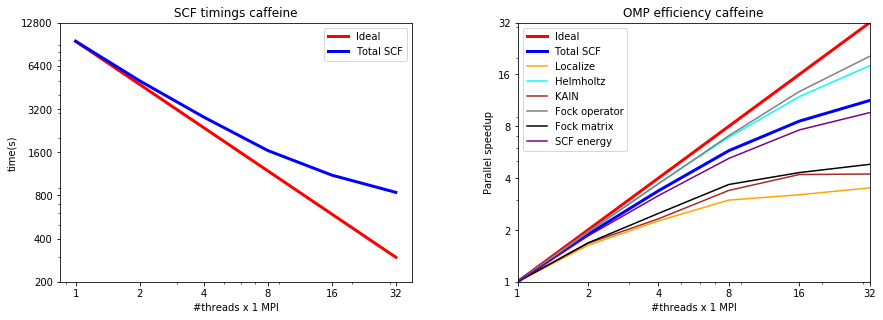

,Localize,SCF energy,Helmholtz,Lowdin,KAIN,Fock operator,Fock matrix,Total SCF
OMP,,,,,,,,
1,539.122,583.3620,7030.860,91.8980,58.2897,434.3580,701.451,9485.070
2,330.939,316.2900,3616.870,54.8294,34.8212,223.9340,417.278,5027.040
4,238.849,184.3320,1889.190,45.0962,25.1186,117.2300,281.145,2810.330
8,180.755,112.0400,1017.250,37.7111,17.1773,61.5682,190.918,1642.940
16,168.410,76.5883,591.590,35.1696,13.8922,34.1444,162.889,1107.300
32,153.471,60.7382,390.757,31.6127,13.7935,21.3100,145.833,839.766


In [38]:
mpi=1
mol='caffeine'
omp_frame = pd.read_csv("caffeine/scf.csv", index_col=[0,1,2])
omp_series = omp_frame.loc[mol,mpi]

plt.subplot(121)
plt.title('SCF timings ' + mol)
plt.plot(omp_series.index, mpi*omp_series['Total SCF'][mpi]/omp_series.index, c='red', lw=3, label='Ideal')
plt.plot(omp_series['Total SCF'], c='blue', lw=3, label='Total SCF')
plt.legend(loc='upper right')
plt.yscale('log')
plt.xscale('log')
plt.yticks([200, 400, 800, 1600, 3200, 6400, 12800], [200, 400, 800, 1600, 3200, 6400, 12800])
plt.xticks([1, 2, 4, 8, 16, 32], [1, 2, 4, 8, 16, 32])
plt.ylabel('time(s)')
plt.xlabel('#threads' + ' x ' + str(mpi) + ' MPI')

plt.subplot(122)
plt.title('OMP efficiency ' + mol)
plt.plot(omp_series.index, omp_series.index, c='red', lw=3, label='Ideal')
plt.plot(mpi*omp_series['Total SCF'][mpi]/omp_series['Total SCF'], c='blue', lw=3, label='Total SCF')
plt.plot(mpi*omp_series['Localize'][mpi]/omp_series['Localize'], c='orange', label='Localize')
plt.plot(mpi*omp_series['Helmholtz'][mpi]/omp_series['Helmholtz'], c='cyan', label='Helmholtz')
plt.plot(mpi*omp_series['KAIN'][mpi]/omp_series['KAIN'], c='brown', label='KAIN')
plt.plot(mpi*omp_series['Fock operator'][mpi]/omp_series['Fock operator'], c='gray', label='Fock operator')
plt.plot(mpi*omp_series['Fock matrix'][mpi]/omp_series['Fock matrix'], c='black', label='Fock matrix')
plt.plot(mpi*omp_series['SCF energy'][mpi]/omp_series['SCF energy'], c='purple', label='SCF energy')
plt.legend(loc='upper left')
plt.axis([8, 32, 8, 32])
plt.yscale('log')
plt.xscale('log')
plt.yticks([1, 2, 4, 8, 16, 32], [1, 2, 4, 8, 16, 32])
plt.xticks([1, 2, 4, 8, 16, 32], [1, 2, 4, 8, 16, 32])
plt.ylabel('Parallel speedup')
plt.xlabel('#threads' + ' x ' + str(mpi) + ' MPI')

plt.subplots_adjust(top=1.0, bottom=0.1, right=2, wspace=.30)
plt.show()
omp_frame.loc[mol,mpi,:]

## MPI scaling

The following table presents timings (in sec) for the different parts of a single SCF cycle for the Caffeine ($C_{8}H_{10}N_{4}O_{2}$) molecule at numerical precision $\epsilon=10^{-5}$, using the PBE density functional. The calculations are using an increasing number of MPI processes with fixed a single OMP threads per process. The molecule has 102 electrons and 51 doubly occupied molecular orbitals.

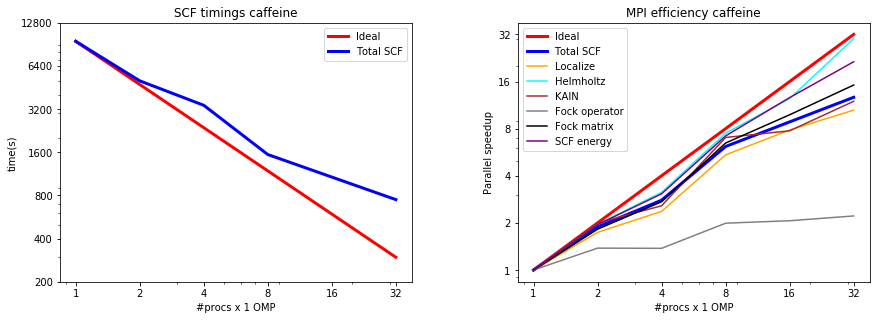

,Localize,SCF energy,Helmholtz,Lowdin,KAIN,Fock operator,Fock matrix,Total SCF
MPI,,,,,,,,
1,539.1220,583.3620,7030.860,91.8980,58.28970,434.358,701.4510,9485.07
2,309.7110,299.3990,3590.120,62.7896,29.19360,314.786,384.8410,5028.01
4,227.5730,190.1270,2243.160,102.8340,22.65090,315.690,257.0250,3395.95
8,99.0909,81.1366,940.197,64.4991,8.29754,218.139,108.3210,1541.12
16,68.7621,46.1696,565.023,83.2723,7.52526,210.423,71.4999,1073.54
32,51.3052,27.2636,233.711,167.4980,4.87395,196.089,46.1821,747.64


In [43]:
omp=1
ref=1
mol='caffeine'
mpi_frame = pd.read_csv("caffeine/scf.csv", index_col=[0,2,1])
mpi_series = mpi_frame.loc[mol,omp]

plt.subplot(121)
plt.title('SCF timings ' + mol)
plt.plot(mpi_series.index, ref*mpi_series['Total SCF'][ref]/mpi_series.index, c='red', lw=3, label='Ideal')
plt.plot(mpi_series['Total SCF'], c='blue', lw=3, label='Total SCF')
plt.legend(loc='upper right')
plt.yscale('log')
plt.xscale('log')
plt.yticks([200, 400, 800, 1600, 3200, 6400, 12800], [200, 400, 800, 1600, 3200, 6400, 12800])
plt.xticks([1, 2, 4, 8, 16, 32], [1, 2, 4, 8, 16, 32])
plt.ylabel('time(s)')
plt.xlabel('#procs' + ' x ' + str(omp) + ' OMP')

plt.subplot(122)
plt.title('MPI efficiency ' + mol)
plt.plot(mpi_series.index, mpi_series.index, c='red', lw=3, label='Ideal')
plt.plot(ref*mpi_series['Total SCF'][ref]/mpi_series['Total SCF'], c='blue', lw=3, label='Total SCF')
plt.plot(ref*mpi_series['Localize'][ref]/mpi_series['Localize'], c='orange', label='Localize')
plt.plot(ref*mpi_series['Helmholtz'][ref]/mpi_series['Helmholtz'], c='cyan', label='Helmholtz')
plt.plot(ref*mpi_series['KAIN'][ref]/mpi_series['KAIN'], c='brown', label='KAIN')
plt.plot(ref*mpi_series['Fock operator'][ref]/mpi_series['Fock operator'], c='gray', label='Fock operator')
plt.plot(ref*mpi_series['Fock matrix'][ref]/mpi_series['Fock matrix'], c='black', label='Fock matrix')
plt.plot(ref*mpi_series['SCF energy'][ref]/mpi_series['SCF energy'], c='purple', label='SCF energy')
plt.legend(loc='upper left')
plt.yscale('log')
plt.xscale('log')
plt.yticks([1, 2, 4, 8, 16, 32], [1, 2, 4, 8, 16, 32])
plt.xticks([1, 2, 4, 8, 16, 32], [1, 2, 4, 8, 16, 32])
plt.ylabel('Parallel speedup')
plt.xlabel('#procs' + ' x ' + str(omp) + ' OMP')

plt.subplots_adjust(top=1.0, bottom=0.1, right=2, wspace=.30)
plt.show()
mpi_frame.loc[mol,omp]

## Hybrid MPI/OpenMP scaling

The following table presents timings (in sec) for the different parts of a single SCF cycle for the Caffeine ($C_{8}H_{10}N_{4}O_{2}$) molecule at numerical precision $\epsilon=10^{-5}$, using the PBE density functional. The calculations are using an increasing number of MPI processes with fixed 16 OMP threads per process. The molecule has 102 electrons and 51 doubly occupied molecular orbitals.

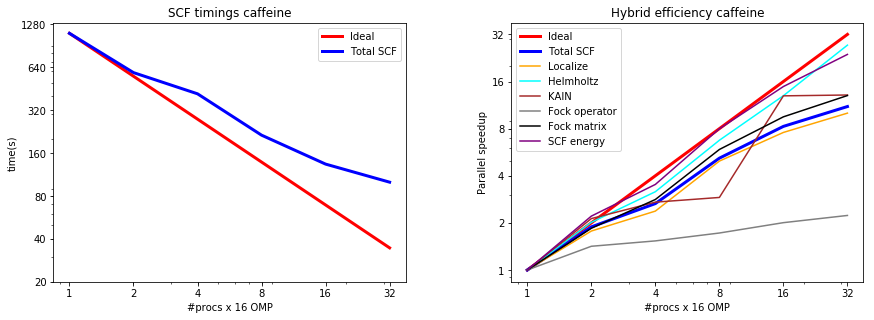

,Localize,SCF energy,Helmholtz,Lowdin,KAIN,Fock operator,Fock matrix,Total SCF
MPI,,,,,,,,
1,168.4100,76.58830,591.5900,35.1696,13.89220,34.1444,162.8890,1107.3000
2,94.9403,34.67040,293.4250,26.7317,6.52117,24.0802,88.1761,587.0670
4,70.8022,21.75180,187.0110,33.9331,5.11962,22.2504,57.7466,416.7850
8,33.9335,9.59366,87.7386,22.5452,4.77807,19.8133,27.6647,213.7110
16,22.2623,5.15317,45.5505,17.1102,1.07208,17.0147,17.1129,133.9050
32,16.7586,3.21311,21.6575,21.5172,1.05878,15.3030,12.5151,99.9972


In [46]:
omp=16
ref=1
mol='caffeine'
hybrid_frame = pd.read_csv("caffeine/scf.csv", index_col=[0,2,1])
hybrid_series = hybrid_frame.loc[mol,omp]

plt.subplot(121)
plt.title('SCF timings ' + mol)
plt.plot(hybrid_series.index, ref*hybrid_series['Total SCF'][ref]/hybrid_series.index, c='red', lw=3, label='Ideal')
plt.plot(hybrid_series['Total SCF'], c='blue', lw=3, label='Total SCF')
plt.legend(loc='upper right')
plt.yscale('log')
plt.xscale('log')
plt.yticks([20, 40, 80, 160, 320, 640, 1280], [20, 40, 80, 160, 320, 640, 1280])
plt.xticks([1, 2, 4, 8, 16, 32], [1, 2, 4, 8, 16, 32])
plt.ylabel('time(s)')
plt.xlabel('#procs' + ' x ' + str(omp) + ' OMP')

plt.subplot(122)
plt.title('Hybrid efficiency ' + mol)
plt.plot(hybrid_series.index, hybrid_series.index, c='red', lw=3, label='Ideal')
plt.plot(ref*hybrid_series['Total SCF'][ref]/hybrid_series['Total SCF'], c='blue', lw=3, label='Total SCF')
plt.plot(ref*hybrid_series['Localize'][ref]/hybrid_series['Localize'], c='orange', label='Localize')
plt.plot(ref*hybrid_series['Helmholtz'][ref]/hybrid_series['Helmholtz'], c='cyan', label='Helmholtz')
plt.plot(ref*hybrid_series['KAIN'][ref]/hybrid_series['KAIN'], c='brown', label='KAIN')
plt.plot(ref*hybrid_series['Fock operator'][ref]/hybrid_series['Fock operator'], c='gray', label='Fock operator')
plt.plot(ref*hybrid_series['Fock matrix'][ref]/hybrid_series['Fock matrix'], c='black', label='Fock matrix')
plt.plot(ref*hybrid_series['SCF energy'][ref]/hybrid_series['SCF energy'], c='purple', label='SCF energy')
plt.legend(loc='upper left')
plt.yscale('log')
plt.xscale('log')
plt.yticks([1, 2, 4, 8, 16, 32], [1, 2, 4, 8, 16, 32])
plt.xticks([1, 2, 4, 8, 16, 32], [1, 2, 4, 8, 16, 32])
plt.ylabel('Parallel speedup')
plt.xlabel('#procs' + ' x ' + str(omp) + ' OMP')

plt.subplots_adjust(top=1.0, bottom=0.1, right=2, wspace=.30)
plt.show()
mpi_frame.loc[mol,omp,:]